This Jupyter notebook replicates the expeliments by Eigenmann et al(2017)., PKPD modeling of acquired resistance to anti-cancer drug.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5686279/

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

1. Implement PK model

In [2]:
# Given parameter for Erlotinib (k2 for high dosage is modified)
ka=55
ke=7.56
V=0.127
I=0
lambda0 = 0.217
lambda1 = 42.8
beta = 0.869
kSR=7.4*10**(-3)
#kSR=1.7*10**(-3)
k1=1.52
#k2 = 9.21*10**(-5)
k2 = 3.15*10**(-1.5)
tau = 1.97

In [3]:
# Make an assumption on D, which is not given in the paper
D = 5

In [4]:
# PK model
def model_PK(x,t):
    # Give initial value to the parameters
    Ad = x[0]
    Ap = x[1]
    Cp = x[2]

    # Define each ODE
    dAddt = -ka*Ad
    dApdt = ka*Ad - ke*Ap
    Cp = dApdt/(V-D*I)

    return [dAddt, dApdt, Cp]

In [5]:
# Initial value for PK model
x0_PK = [D,0,0]

In [6]:
# Solve the ODE
t = np.linspace(0,2,300)
results = odeint(model_PK, x0_PK, t)

Text(0, 0.5, 'Val.')

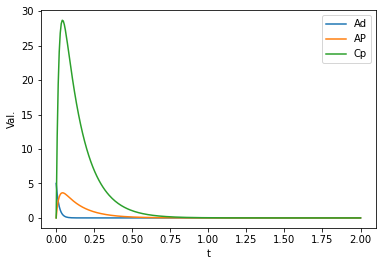

In [7]:
# Figure
fig,ax = plt.subplots()
ax.plot(t,results[:,0],label = 'Ad')
ax.plot(t,results[:,1],label='AP')
ax.plot(t,results[:,2],label='Cp')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Val.')

2. Implement TGI base model

In [8]:
def TGI(x, t):
    # Give initial value to the parameters
    Ad = x[0]
    Ap = x[1]
    Cp = x[2]

    S = x[3]
    T1 = x[4]
    T2 = x[5]
    T3 = x[6]
    TV = x[7]

    # Define each ODE
    dAddt = -ka*Ad
    dApdt = ka*Ad - ke*Ap
    Cp = dApdt/(V-D*I)

    dSdt = (2*lambda0*lambda1*S)/(2*lambda0*S+lambda1) -k2*Ap/(V-(D*I))*S
    dT1dt = k2*S*Ap/(V-(D*I)) - T1*k1
    dT2dt = k1*(T1-T2)
    dT3dt = k1*(T2-T3)
    TV = dSdt+dT1dt+dT2dt+dT3dt

    return [dAddt, dApdt, Cp, dSdt, dT1dt, dT2dt, dT3dt, TV]

In [9]:
# Initial condition for TGI base model
TV0 = 100
x0_TGI = [5,0,0,TV0,0,0,0,TV0]

In [10]:
# Medication only first 14 days
cummulative_TGI = []
for i in range(30):
    t = np.linspace(0,1,11)
    if i ==0:
        initial = x0_TGI
    elif i < 14:
        initial = results[-1]+np.array([5,0,0,0,0,0,0,0])
    else:
        initial = results[-1]
    results = odeint(TGI, initial, t)
    for j in range(len(results)):
        cummulative_TGI.append(list(results[j]))

cummulative_TGI = np.array(cummulative_TGI)

Text(0, 0.5, 'Val.')

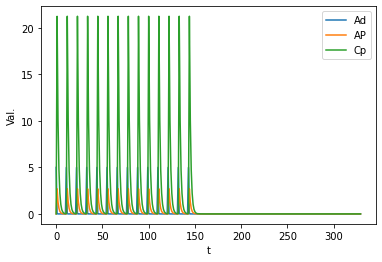

In [11]:
# Check the output for the PK model
fig,ax = plt.subplots()
x = list(range(len(cummulative_TGI)))
ax.plot(x,cummulative_TGI[:,0],label = 'Ad')
ax.plot(x,cummulative_TGI[:,1],label='AP')
ax.plot(x,cummulative_TGI[:,2],label='Cp')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Val.')

Text(0, 0.5, 'Tumor Volume')

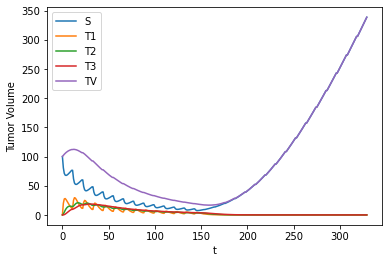

In [12]:
# The dynamics of the tumor cells
fig,ax = plt.subplots()
ax.plot(x,cummulative_TGI[:,3],label = 'S')
ax.plot(x,cummulative_TGI[:,4],label='T1')
ax.plot(x,cummulative_TGI[:,5],label='T2')
ax.plot(x,cummulative_TGI[:,6],label='T3')
ax.plot(x,cummulative_TGI[:,7],label='TV')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Tumor Volume')

Text(0, 0.5, 'Tumor Volume')

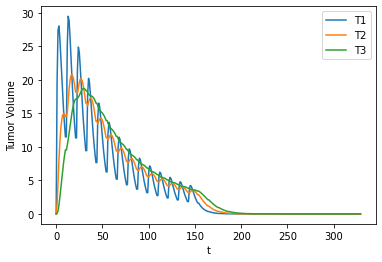

In [13]:
# The dynamics of damaged cells
fig,ax = plt.subplots()
ax.plot(x,cummulative_TGI[:,4],label='T1')
ax.plot(x,cummulative_TGI[:,5],label='T2')
ax.plot(x,cummulative_TGI[:,6],label='T3')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Tumor Volume')

(1, 10000)

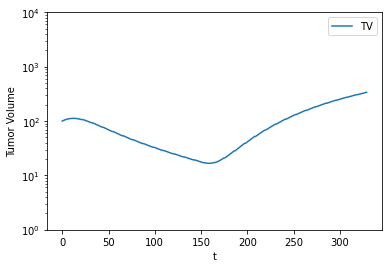

In [14]:
# The dynamics of the Tumor size; this should be Figure 3 in the paper
fig,ax = plt.subplots()
ax.plot(x,cummulative_TGI[:,7],label='TV')
ax.legend()
ax.set_xlabel('t')
ax.set_yscale('log',basey=10)
ax.set_ylabel('Tumor Volume')
ax.set_ylim([10**0,10**4])

3. Resistance model

In [15]:
def Resistance(x, t):
    # Give initial value to the parameters
    Ad = x[0]
    Ap = x[1]
    Cp = x[2]

    S = x[3]
    T1 = x[4]
    T2 = x[5]
    T3 = x[6]
    TV = x[7]

    R = x[8]

    # Define each ODE
    dAddt = -ka*Ad
    dApdt = ka*Ad - ke*Ap
    Cp = dApdt/(V-D*I)

    dSdt = (2*lambda0*lambda1*S)/(2*lambda0*S+lambda1) - k2*Ap/(V-(D*I))*S
    dT1dt = k2*S*Ap/(V-(D*I)) - T1*k1
    dT2dt = k1*(T1-T2)
    dT3dt = k1*(T2-T3) - kSR*T3
    TV = dSdt + dT1dt + dT2dt + dT3dt

    lambda0R = beta*lambda0
    lambda1R = beta*lambda1

    DER = 0
    '''
    if Cp > 10:
        DER = Cp*0.0001
    '''
    dRdt = (2*lambda0R*lambda1R*R)/(2*lambda0R*R+lambda1R) +kSR*T3 - DER

    return [dAddt, dApdt, Cp, dSdt, dT1dt, dT2dt, dT3dt, TV, dRdt]

In [16]:
# The initial condition for the desistance model
TV0 = 100
x0_Resistance = [5,0,0,TV0,0,0,0,TV0, 0]

In [17]:
# Medication only first 14 days with (resistance model)
cummulative_r = []
for i in range(30):
    t = np.linspace(0,1,11)
    if i ==0:
        initial = x0_Resistance
    elif i < 14:
        initial = results[-1]+np.array([5,0,0,0,0,0,0,0,0])
    else:
        initial = results[-1]
    results = odeint(Resistance, initial, t)
    for j in range(len(results)):
        cummulative_r.append(list(results[j]))

cummulative_r = np.array(cummulative_r)

Text(0, 0.5, 'Val.')

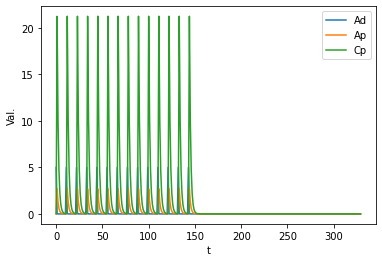

In [18]:
# Check the outcome of the PK model
fig,ax = plt.subplots()
ax.plot(x,cummulative_r[:,0],label='Ad')
ax.plot(x,cummulative_r[:,1],label='Ap')
ax.plot(x,cummulative_r[:,2],label='Cp')

ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Val.')

Text(0, 0.5, 'Tumor Volume')

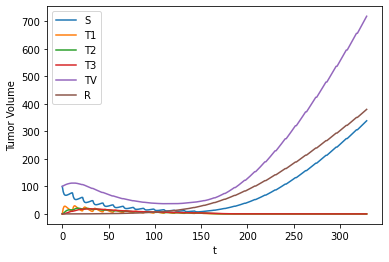

In [19]:
# Check the tumor dynamics
fig,ax = plt.subplots()
ax.plot(x,cummulative_r[:,3],label = 'S')
ax.plot(x,cummulative_r[:,4],label='T1')
ax.plot(x,cummulative_r[:,5],label='T2')
ax.plot(x,cummulative_r[:,6],label='T3')
ax.plot(x,cummulative_r[:,7]+cummulative_r[:,8],label='TV')
ax.plot(x,cummulative_r[:,8],label='R')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Tumor Volume')

(1, 10000)

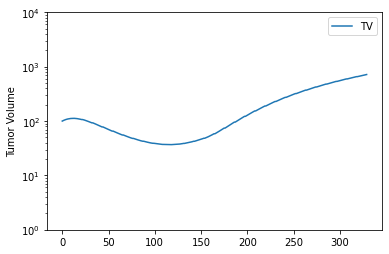

In [20]:
# The dynamics of total tumor size; this should be Figure 3 in the paper
fig,ax = plt.subplots()
ax.plot(x,cummulative_r[:,7]+cummulative_r[:,8],label='TV')
ax.legend()
ax.set_yscale('log',basey=10)
ax.set_ylabel('Tumor Volume')
ax.set_ylim([10**0,10**4])

4. Simulation study with not continuous medication

In [21]:
# Medication only first 14 days with (resistance model)
cummulative_r2 = []
for i in range(30):
    t = np.linspace(0,1,11)
    if i ==0:
        initial = x0_Resistance
        initial[0]=0 
    elif i in [2,3,4,5,6,7,13,14,15]:
        initial = results[-1]+np.array([5,0,0,0,0,0,0,0,0])
    else:
        initial = results[-1]
    results = odeint(Resistance, initial, t)
    for j in range(len(results)):
        cummulative_r2.append(list(results[j]))

cummulative_r2 = np.array(cummulative_r2)

Text(0, 0.5, 'Tumor Volume')

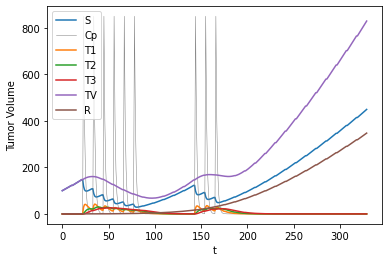

In [22]:
# Check the tumor dynamics; this should be Fiture 5 in the paper
fig,ax = plt.subplots()
ax.plot(x,cummulative_r2[:,3],label = 'S')
ax.plot(x,cummulative_r2[:,2]*40,label = 'Cp', color='gray', linewidth=0.5)
ax.plot(x,cummulative_r2[:,4],label='T1')
ax.plot(x,cummulative_r2[:,5],label='T2')
ax.plot(x,cummulative_r2[:,6],label='T3')
ax.plot(x,cummulative_r2[:,7]+cummulative_r[:,8],label='TV')
ax.plot(x,cummulative_r2[:,8],label='R')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Tumor Volume')

5. Check the effects of treatment strategy

Text(0, 0.5, 'Tumor Volume')

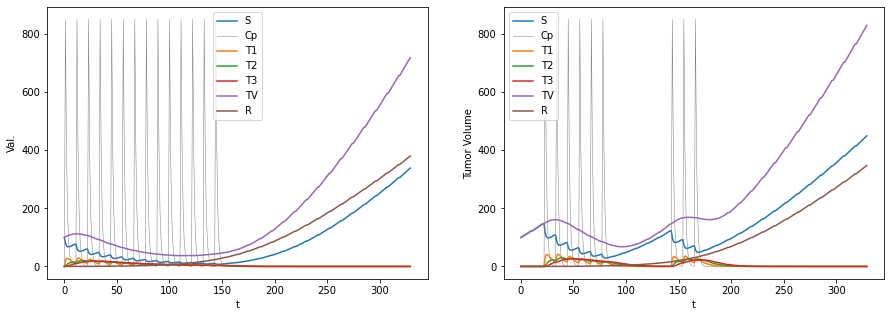

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(x,cummulative_r[:,3],label = 'S')
ax1.plot(x,cummulative_r[:,2]*40,label = 'Cp', color='gray', linewidth=0.5)
ax1.plot(x,cummulative_r[:,4],label='T1')
ax1.plot(x,cummulative_r[:,5],label='T2')
ax1.plot(x,cummulative_r[:,6],label='T3')
ax1.plot(x,cummulative_r[:,7]+cummulative_r[:,8],label='TV')
ax1.plot(x,cummulative_r[:,8],label='R')
ax1.legend()
ax1.set_xlabel('t')
ax1.set_ylabel('Val.')

ax2.plot(x,cummulative_r2[:,3],label = 'S')
ax2.plot(x,cummulative_r2[:,2]*40,label = 'Cp', color='gray', linewidth=0.5)
ax2.plot(x,cummulative_r2[:,4],label='T1')
ax2.plot(x,cummulative_r2[:,5],label='T2')
ax2.plot(x,cummulative_r2[:,6],label='T3')
ax2.plot(x,cummulative_r2[:,7]+cummulative_r[:,8],label='TV')
ax2.plot(x,cummulative_r2[:,8],label='R')
ax2.legend()
ax2.set_xlabel('t')
ax2.set_ylabel('Tumor Volume')